# How to access and load TRACMIP data from the Pangeo cloud

This notebook presents two approaches of accessing TRACMIP data in the Pangeo cloud from your own computer. Both appraoches access zarr-based data in the Google Cloud and in the example provided here result in a dictionary of monthly-mean precipitation in the aquaControl from all TRACMIP models.

As a proof of concept, the notebook closes with plotting the time-averaged precipitation for one of the TRACMIP models using the dictionaries generated by both approaches. Naturally, and in fact naecessarily, the plot is the same for both dictionaries.

## Approach 1 via tracmip.csv

Based on "Way 2: Do the same thing with the Google Cloud Zarr-based data (still from your laptop)" described in Ryan Abernathey's blog post "CMIP6 in the Cloud Five Ways", https://medium.com/pangeo/cmip6-in-the-cloud-five-ways-96b177abe396

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

Browse Catalog: The data catatalog is stored as a CSV file. Here we read it with Pandas.

In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/tracmip.csv')
df.head()

frequency experiment model variable    version  \
0      A3hr  aqua4xCO2  AM21      hur  v20190116   
1      A3hr  aqua4xCO2  AM21      hus  v20190116   
2      A3hr  aqua4xCO2  AM21       ta  v20190116   
3      A3hr  aqua4xCO2  AM21       ua  v20190116   
4      A3hr  aqua4xCO2  AM21       va  v20190116   

                                              source  
0  gs://cmip6/tracmip/A3hr/aqua4xCO2/AM21/hur/v20...  
1  gs://cmip6/tracmip/A3hr/aqua4xCO2/AM21/hus/v20...  
2  gs://cmip6/tracmip/A3hr/aqua4xCO2/AM21/ta/v201...  
3  gs://cmip6/tracmip/A3hr/aqua4xCO2/AM21/ua/v201...  
4  gs://cmip6/tracmip/A3hr/aqua4xCO2/AM21/va/v201...

For the purpose of this example, we filter the data to find monthly precipitation for the aquaControl simulation.

In [3]:
df_pr = df.query("frequency == 'Amon' & variable == 'pr' & experiment == 'aquaControl'")

We check the content of the dataframe. As desired it contains monthly precipitation for the 14 TRACMIP models. The entries in the source column point to the data location in the Google Cloud and are needed to read the data.

In [4]:
df_pr

frequency   experiment         model variable    version  \
4844      Amon  aquaControl          AM21       pr  v20190116   
4879      Amon  aquaControl       CALTECH       pr  v20181025   
4913      Amon  aquaControl          CAM3       pr  v20190129   
4953      Amon  aquaControl          CAM4       pr  v20190409   
4996      Amon  aquaControl       CAM5Nor       pr  v20190305   
5032      Amon  aquaControl      CNRM-AM5       pr  v20180423   
5067      Amon  aquaControl       ECHAM61       pr  v20180423   
5110      Amon  aquaControl       ECHAM63       pr  v20190129   
5153      Amon  aquaControl  GISS-ModelE2       pr  v20190114   
5199      Amon  aquaControl        LMDZ5A       pr  v20190114   
5242      Amon  aquaControl        MIROC5       pr  v20181025   
5284      Amon  aquaControl          MPAS       pr  v20190131   
5324      Amon  aquaControl     MetUM-CTL       pr  v20180423   
5365      Amon  aquaControl     MetUM-ENT       pr  v20180423   

                                                 source  
4844  gs://cmip6/tracmip/Amon/aquaControl/AM21/pr/v2...  
4879  gs://cmip6/tracmip/Amon/aquaControl/CALTECH/pr...  
4913  gs://cmip6/tracmip/Amon/aquaControl/CAM3/pr/v2...  
4953  gs://cmip6/tracmip/Amon/aquaControl/CAM4/pr/v2...  
4996  gs://cmip6/tracmip/Amon/aquaControl/CAM5Nor/pr...  
5032  gs://cmip6/tracmip/Amon/aquaControl/CNRM-AM5/p...  
5067  gs://cmip6/tracmip/Amon/aquaControl/ECHAM61/pr...  
5110  gs://cmip6/tracmip/Amon/aquaControl/ECHAM63/pr...  
5153  gs://cmip6/tracmip/Amon/aquaControl/GISS-Model...  
5199  gs://cmip6/tracmip/Amon/aquaControl/LMDZ5A/pr/...  
5242  gs://cmip6/tracmip/Amon/aquaControl/MIROC5/pr/...  
5284  gs://cmip6/tracmip/Amon/aquaControl/MPAS/pr/v2...  
5324  gs://cmip6/tracmip/Amon/aquaControl/MetUM-CTL/...  
5365  gs://cmip6/tracmip/Amon/aquaControl/MetUM-ENT/...

We are now going to read the data into a dictionary of xarray datasets.

In [5]:
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# initialize an empty dictionary
ds_dict1=dict()

To this end, we loop over the source values to read the data of the individual models and to fill the dictionary. 
As for the dictionary keys we use the model names.

In [6]:
for zstore in df_pr.source.values:
    mapper = gcs.get_mapper(zstore)
    ds = xr.open_zarr(mapper, consolidated=True)
    ds_dict1[ds.attrs['model_id']] = ds

For the sake of demonstration, we print the dictionary content for the ECHAM61 model. 

In [7]:
ds_dict1['ECHAM61']

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 192, time: 360)
Coordinates:
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time       (time) object 0016-01-16 00:00:00 ... 0045-12-16 00:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(360, 96, 192), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.4
    branch_time:            0.0
    cmor_version:           2.9.1
    comment:                aqua planet control of TRACMIP; for TRACMIP see V...
    contact:                aiko@ldeo.columbia.edu; aiko.voigt@kit.edu
    creation_date:          2018-02-25T12:21:01Z
    experiment:             aqua planet control of TRACMIP
    experiment_id:          aquaControlTRACMIP
    forcing:                CTRL
    frequency:              mon
    history:                N/A 2018-02-25T12:21:01Z CMOR rewrote data to com...
    initialization_method:  1
    institute_id:           LDEO
    institution:            Lamont-Doherty Earth Observatory, Columbia Univer...
    model_id:               ECHAM61
    modeling_realm:         atmos
    parent_experiment:      N/A
    parent_experiment_id:   N/A
    parent_experiment_rip:  N/A
    physics_version:        1
    product:                output
    project_id:             TRACMIP
    realization:            1
    references:             ECHAM6.1: Stevens et al., 2013, Atmospheric compo...
    source:                 ECHAM61, 2013, T63, 47 levels;
    table_id:               Table Amon (11 September 2017) b0abd1a83fe45ef2ed...
    title:                  ECHAM61 model output prepared for TRACMIP aqua pl...
    tracking_id:            a6042360-356a-4d4e-8357-9699f6c18da1

## Aproach 2 via intake

This approach was developed with help by Charles Christopher Blackmon Luca.

In [8]:
from intake import open_catalog

In [9]:
# get the entire Pangeo catalogue ...
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/climate.yaml")
# ... and select TRACMIP collection
col = cat.tracmip()

For illustration, we look at some basic information of the TRACMIP collection. AS expected, there is 3 output frequencies (monthly-mean, daily-mean, 3-hr snapshots), 11 experiments (6 are due to the CALTECH model with changed atmosperic opacity), and 47 variables

In [10]:
col

<pangeo-tracmip catalog with 187 dataset(s) from 7067 asset(s)>

To make ourselves a bit more familiar with the collection we print its starting and end portion to screen. This looks just as for appraoch 1, as it must be.

In [11]:
col.df.head()

frequency experiment model variable    version  \
0      A3hr  aqua4xCO2  AM21      hur  v20190116   
1      A3hr  aqua4xCO2  AM21      hus  v20190116   
2      A3hr  aqua4xCO2  AM21       ta  v20190116   
3      A3hr  aqua4xCO2  AM21       ua  v20190116   
4      A3hr  aqua4xCO2  AM21       va  v20190116   

                                              source  
0  gs://cmip6/tracmip/A3hr/aqua4xCO2/AM21/hur/v20...  
1  gs://cmip6/tracmip/A3hr/aqua4xCO2/AM21/hus/v20...  
2  gs://cmip6/tracmip/A3hr/aqua4xCO2/AM21/ta/v201...  
3  gs://cmip6/tracmip/A3hr/aqua4xCO2/AM21/ua/v201...  
4  gs://cmip6/tracmip/A3hr/aqua4xCO2/AM21/va/v201...

In [12]:
col.df.tail()

frequency experiment      model variable    version  \
7062      Amon  landOrbit  MetUM-ENT      uas  v20180423   
7063      Amon  landOrbit  MetUM-ENT       va  v20180423   
7064      Amon  landOrbit  MetUM-ENT      vas  v20180423   
7065      Amon  landOrbit  MetUM-ENT      wap  v20180423   
7066      Amon  landOrbit  MetUM-ENT       zg  v20180423   

                                                 source  
7062  gs://cmip6/tracmip/Amon/landOrbit/MetUM-ENT/ua...  
7063  gs://cmip6/tracmip/Amon/landOrbit/MetUM-ENT/va...  
7064  gs://cmip6/tracmip/Amon/landOrbit/MetUM-ENT/va...  
7065  gs://cmip6/tracmip/Amon/landOrbit/MetUM-ENT/wa...  
7066  gs://cmip6/tracmip/Amon/landOrbit/MetUM-ENT/zg...

Now we load the monthly-mean precip data for the aquaControl experiment into a dictionary, in analogy to what we did for approach 1.

Note: the option "zarr_kwargs={'consolidated': True}" for to_dataset_dicts does not seem necessary but is still included here.

In [13]:
ds_dict2 = col.search(frequency="Amon", experiment="aquaControl",
                     variable="pr").to_dataset_dict(zarr_kwargs={'consolidated': True})

Dataset(s):   0%|                                       | 0/14 [00:00<?, ?it/s]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'model.experiment.frequency'


Dataset(s): 100%|██████████████████████████████| 14/14 [00:07<00:00,  1.79it/s]


For the sake of demonstration, we print the dictionary content for the ECHAM61 model. Note that the keys are now 'model.experiment.frequency'.

In [14]:
ds_dict2['ECHAM61.aquaControl.Amon']

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 192, time: 360)
Coordinates:
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time       (time) object 0016-01-16 00:00:00 ... 0045-12-16 00:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(360, 96, 192), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.4
    branch_time:             0.0
    cmor_version:            2.9.1
    comment:                 aqua planet control of TRACMIP; for TRACMIP see ...
    contact:                 aiko@ldeo.columbia.edu; aiko.voigt@kit.edu
    creation_date:           2018-02-25T12:21:01Z
    experiment:              aqua planet control of TRACMIP
    experiment_id:           aquaControlTRACMIP
    forcing:                 CTRL
    frequency:               mon
    history:                 N/A 2018-02-25T12:21:01Z CMOR rewrote data to co...
    initialization_method:   1
    institute_id:            LDEO
    institution:             Lamont-Doherty Earth Observatory, Columbia Unive...
    model_id:                ECHAM61
    modeling_realm:          atmos
    parent_experiment:       N/A
    parent_experiment_id:    N/A
    parent_experiment_rip:   N/A
    physics_version:         1
    product:                 output
    project_id:              TRACMIP
    realization:             1
    references:              ECHAM6.1: Stevens et al., 2013, Atmospheric comp...
    source:                  ECHAM61, 2013, T63, 47 levels;
    table_id:                Table Amon (11 September 2017) b0abd1a83fe45ef2e...
    title:                   ECHAM61 model output prepared for TRACMIP aqua p...
    tracking_id:             a6042360-356a-4d4e-8357-9699f6c18da1
    intake_esm_varname:      pr
    intake_esm_dataset_key:  ECHAM61.aquaControl.Amon

## Plot zonal-mean time-mean precip for last 20 years for ECHAM61 model using the dictionaries from the two approaches

In [15]:
import matplotlib.pyplot as plt

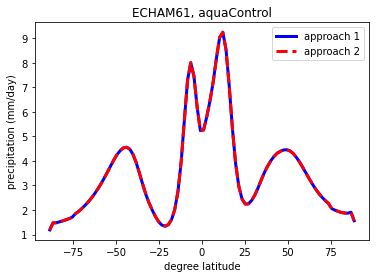

In [16]:
plt.plot(ds_dict1['ECHAM61'].lat, 
         ds_dict1['ECHAM61']['pr'].isel(time=slice(120,360)).mean(['lon', 'time'])*86400,
        'b', linewidth=3, label='approach 1')
plt.plot(ds_dict2['ECHAM61.aquaControl.Amon'].lat, 
         ds_dict2['ECHAM61.aquaControl.Amon']['pr'].isel(time=slice(120,360)).mean(['lon', 'time'])*86400,
        'r--', linewidth=3, label='approach 2')
plt.xlabel('degree latitude')
plt.ylabel('precipitation (mm/day)')
plt.title('ECHAM61, aquaControl');
plt.legend();

## Closing remark

The above hopefully provides a helpful and clear recipe for accessing TRACMIP data from the Pangeo Cloud. It should be straightforward to condense the approaches into wrapper functions.